##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object detection with Model Garden
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/vision/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial fine-tunes a [RetinaNet](https://arxiv.org/abs/1708.02002) with ResNet-50 as backbone model from the [TensorFlow Model Garden](https://pypi.org/project/tf-models-official/) package (tensorflow-models) to detect three different Blood Cells in [BCCD](https://public.roboflow.com/object-detection/bccd) dataset. The RetinaNet is pretrained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017

[Model Garden](https://www.tensorflow.org/tfmodels) contains a collection of state-of-the-art models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

This tutorial demonstrates how to:

1. Use models from the Tensorflow Model Garden(TFM) package.
2. Fine-tune a pre-trained RetinanNet with ResNet-50 as backbone for object detection.
3. Export the tuned RetinaNet model

## Install necessary dependencies

In [1]:
!pip install -U "tf-models-official"
%ls


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
TF_object_detection_training_colab.ipynb
adam_pipeline.config
data/
deploy/
generate_tfrecord.py
local_inference_test.ipynb
local_inference_test.py
models/
object_detection.ipynb
official/
report.txt
requirements.txt
resize_images.py
sy-train.ipynb
venv/
xml_to_csv.py


## Import required libraries

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

## Import required libraries from tensorflow models

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.18.0


## Custom dataset preparation for object detection

Models in official repository(of model-garden) requires data in a TFRecords format.


Please check [this resource](https://www.tensorflow.org/tutorials/load_data/tfrecord) to learn more about TFRecords data format.


### Upload your custom data in drive or local disk of the notebook and unzip the data

In [5]:
!curl -L 'https://public.roboflow.com/ds/ZpYLqHeT0W?key=ZXfZLRnhsc' > './BCCD.v1-bccd.coco.zip'
!unzip -q -o './BCCD.v1-bccd.coco.zip' -d './BCC.v1-bccd.coco/'
!rm './BCCD.v1-bccd.coco.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100   892  100   892    0     0   3391      0 --:--:-- --:--:-- --:--:--  3391


100 15.2M  100 15.2M    0     0  28.7M      0 --:--:-- --:--:-- --:--:--  288M


### CLI command to convert data(train data).

In [4]:
%ls


TF_object_detection_training_colab.ipynb
adam_pipeline.config
data/
deploy/
generate_tfrecord.py
local_inference_test.ipynb
local_inference_test.py
models/
object_detection.ipynb
official/
report.txt
requirements.txt
resize_images.py
sy-train.ipynb
venv/
xml_to_csv.py


In [ ]:
Split validation data from test data

In [14]:
import os
import shutil
import random

# Path to the directory containing images and XML annotations
train_dir = '/Users/minimal/dev/EPFL_TF_object_detection/data/images/train'

# New validation directory to create
val_output_dir = '/Users/minimal/dev/EPFL_TF_object_detection/data/images/validation'

# Percentage split for validation data (e.g., 20% for validation, 80% remains in train)
val_split = 0.2

# Get a list of all images and XML files (assuming they have the same name)
image_files = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.png'))]
xml_files = [f.replace('.jpg', '.xml').replace('.png', '.xml') for f in image_files]

# Ensure the lists match
assert len(image_files) == len(xml_files), "Mismatch between image and XML files"

# Shuffle the image files
data = list(zip(image_files, xml_files))
random.shuffle(data)

# Calculate split index for validation data
num_files = len(data)
val_end = int(val_split * num_files)

# Split data into validation set (the first 20% will be moved to validation)
val_data = data[:val_end]

# Function to move files to the validation directory
def move_files_to_validation(data, source_dir, target_dir):
    for image_file, xml_file in data:
        # Move image
        shutil.move(os.path.join(source_dir, image_file), os.path.join(target_dir, image_file))
        # Move XML annotation
        shutil.move(os.path.join(source_dir, xml_file), os.path.join(target_dir, xml_file))

# Ensure the target validation directory exists
os.makedirs(val_output_dir, exist_ok=True)

# Move the validation files to the validation directory
move_files_to_validation(val_data, train_dir, val_output_dir)

print(f"Validation data split complete! {len(val_data)} files moved to {val_output_dir}.")


Validation data split complete! 501 files moved to /Users/minimal/dev/EPFL_TF_object_detection/data/images/validation.


In [ ]:
#Create annotations json

In [15]:
import os
import xml.etree.ElementTree as ET
import json

# Function to parse the XML file and extract the relevant data
def parse_xml(xml_path, image_id, category_id_map):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find('filename').text
    width = int(root.find('size/width').text)  # You can replace these with actual values from XML
    height = int(root.find('size/height').text)
    
    # Initialize annotations list
    annotations = []
    
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        
        # Add category if it doesn't exist
        if class_name not in category_id_map:
            category_id_map[class_name] = len(category_id_map) + 1
        
        # Prepare annotation dictionary
        annotation_info = {
            "image_id": image_id,
            "category_id": category_id_map[class_name],
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
            "area": (xmax - xmin) * (ymax - ymin),
            "iscrowd": 0,
            "id": len(annotations) + 1
        }
        annotations.append(annotation_info)

    # Image info
    image_info = {
        "file_name": filename,
        "height": height,
        "width": width,
        "id": image_id
    }

    return image_info, annotations

# Function to convert all XML files in a directory to a COCO formatted JSON file
def convert_xml_to_coco(xml_dir, output_json):
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_id_map = {}  # Map to store class name to category id mapping
    image_id = 1
    annotation_id = 1
    
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_dir, xml_file)
            
            # Parse XML and update COCO format
            image_info, annotations = parse_xml(xml_path, image_id, category_id_map)
            
            # Add image info to COCO
            coco_format["images"].append(image_info)
            coco_format["annotations"].extend(annotations)
            
            # Add categories to COCO format
            for class_name, category_id in category_id_map.items():
                category_info = {
                    "id": category_id,
                    "name": class_name,
                    "supercategory": "animal"  # You can customize supercategory
                }
                if not any(cat['id'] == category_id for cat in coco_format["categories"]):
                    coco_format["categories"].append(category_info)
            
            image_id += 1
    
    # Save data to a JSON file
    with open(output_json, 'w') as json_file:
        json.dump(coco_format, json_file, indent=4)
    print(f'COCO-formatted JSON file saved at {output_json}')

# Directories for train, validation, and test data
directories = {
    'train': '/Users/minimal/dev/EPFL_TF_object_detection/data/images/train',
    'validation': '/Users/minimal/dev/EPFL_TF_object_detection/data/images/validation',
    'test': '/Users/minimal/dev/EPFL_TF_object_detection/data/images/test'
}

# Convert XML annotations for each directory to COCO format
for dataset, xml_dir in directories.items():
    output_json = f'/Users/minimal/dev/EPFL_TF_object_detection/data/images/{dataset}/{dataset}_annotations_coco.json'
    convert_xml_to_coco(xml_dir, output_json)


COCO-formatted JSON file saved at /Users/minimal/dev/EPFL_TF_object_detection/data/images/train/train_annotations_coco.json
COCO-formatted JSON file saved at /Users/minimal/dev/EPFL_TF_object_detection/data/images/validation/validation_annotations_coco.json
COCO-formatted JSON file saved at /Users/minimal/dev/EPFL_TF_object_detection/data/images/test/test_annotations_coco.json


In [7]:
%ls

TF_object_detection_training_colab.ipynb
adam_pipeline.config
data/
deploy/
generate_tfrecord.py
local_inference_test.ipynb
local_inference_test.py
models/
object_detection.ipynb
official/
report.txt
requirements.txt
resize_images.py
sy-train.ipynb
venv/
xml_to_csv.py


In [16]:
%%bash

TRAIN_DATA_DIR='./data/images/train'
TRAIN_ANNOTATION_FILE_DIR='./data/images/train/train_annotations_coco.json'
OUTPUT_TFRECORD_TRAIN='./bccd_coco_tfrecords/train'

# Need to provide
  # 1. image_dir: where images are present
  # 2. object_annotations_file: where annotations are listed in json format
  # 3. output_file_prefix: where to write output convered TFRecords files
python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${TRAIN_DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

I0114 19:04:18.876022 8601584192 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/train
I0114 19:04:18.888381 8601584192 create_coco_tf_record.py:374] Building bounding box index.
I0114 19:04:18.888832 8601584192 create_coco_tf_record.py:385] 93 images are missing bboxes.
I0114 19:04:27.498277 8601584192 tfrecord_lib.py:168] On image 0
I0114 19:04:27.549885 8601584192 tfrecord_lib.py:168] On image 100
I0114 19:04:27.596606 8601584192 tfrecord_lib.py:168] On image 200
I0114 19:04:27.653814 8601584192 tfrecord_lib.py:168] On image 300
I0114 19:04:27.720534 8601584192 tfrecord_lib.py:168] On image 400
I0114 19:04:27.764967 8601584192 tfrecord_lib.py:168] On image 500
I0114 19:04:27.809406 8601584192 tfrecord_lib.py:168] On image 600
I0114 19:04:27.854912 8601584192 tfrecord_lib.py:168] On image 700
I0114 19:04:27.900222 8601584192 tfrecord_lib.py:168] On image 800
I0114 19:04:27.940763 8601584192 tfrecord_lib.py:168] On image 900
I0114 19:04:27.991824 8601584192

2023-11-09 12:15:24.203959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


2023-11-09 12:15:24.203987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-11-09 12:15:27.899086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.


Skipping registering GPU devices...


I1109 12:15:27.900500 140558803519296 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/train


I1109 12:15:28.110808 140558803519296 create_coco_tf_record.py:374] Building bounding box index.


I1109 12:15:28.112704 140558803519296 create_coco_tf_record.py:385] 0 images are missing bboxes.


I1109 12:15:28.376975 140558803519296 tfrecord_lib.py:168] On image 0


I1109 12:15:28.383184 140558803519296 tfrecord_lib.py:168] On image 100


I1109 12:15:28.388326 140558803519296 tfrecord_lib.py:168] On image 200


I1109 12:15:28.393295 140558803519296 tfrecord_lib.py:168] On image 300


I1109 12:15:28.398152 140558803519296 tfrecord_lib.py:168] On image 400


I1109 12:15:28.403067 140558803519296 tfrecord_lib.py:168] On image 500


I1109 12:15:28.407919 140558803519296 tfrecord_lib.py:168] On image 600


I1109 12:15:28.412595 140558803519296 tfrecord_lib.py:168] On image 700


I1109 12:15:28.438800 140558803519296 tfrecord_lib.py:180] Finished writing, skipped 6 annotations.


I1109 12:15:28.445898 140558803519296 create_coco_tf_record.py:537] Finished writing, skipped 6 annotations.


### CLI command to convert data(validation data).

In [17]:
%%bash

VALID_DATA_DIR='/Users/minimal/dev/EPFL_TF_object_detection/data/images/validation'
VALID_ANNOTATION_FILE_DIR='/Users/minimal/dev/EPFL_TF_object_detection/data/images/validation/validation_annotations_coco.json'
OUTPUT_TFRECORD_VALID='./bccd_coco_tfrecords/valid'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$VALID_DATA_DIR \
  --object_annotations_file=$VALID_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_VALID \
  --num_shards=1

I0114 19:05:31.302671 8601584192 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/valid
I0114 19:05:31.306113 8601584192 create_coco_tf_record.py:374] Building bounding box index.
I0114 19:05:31.306221 8601584192 create_coco_tf_record.py:385] 20 images are missing bboxes.
I0114 19:05:36.727567 8601584192 tfrecord_lib.py:168] On image 0
I0114 19:05:36.788303 8601584192 tfrecord_lib.py:168] On image 100
I0114 19:05:36.826616 8601584192 tfrecord_lib.py:168] On image 200
I0114 19:05:36.860172 8601584192 tfrecord_lib.py:168] On image 300
I0114 19:05:36.899981 8601584192 tfrecord_lib.py:168] On image 400
I0114 19:05:36.932562 8601584192 tfrecord_lib.py:168] On image 500
I0114 19:05:38.030236 8601584192 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0114 19:05:38.042220 8601584192 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


2023-11-09 12:15:29.695909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


2023-11-09 12:15:29.695940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-11-09 12:15:33.418966: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.


Skipping registering GPU devices...


I1109 12:15:33.419316 140466682771264 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/valid


I1109 12:15:33.426927 140466682771264 create_coco_tf_record.py:374] Building bounding box index.


I1109 12:15:33.427194 140466682771264 create_coco_tf_record.py:385] 0 images are missing bboxes.


I1109 12:15:33.632256 140466682771264 tfrecord_lib.py:168] On image 0


I1109 12:15:33.659518 140466682771264 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.


I1109 12:15:33.660955 140466682771264 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


### CLI command to convert data(test data).

In [18]:
%%bash

TEST_DATA_DIR='/Users/minimal/dev/EPFL_TF_object_detection/data/images/test'
TEST_ANNOTATION_FILE_DIR='/Users/minimal/dev/EPFL_TF_object_detection/data/images/test/test_annotations_coco.json'
OUTPUT_TFRECORD_TEST='./bccd_coco_tfrecords/test'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$TEST_DATA_DIR \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

I0114 19:06:21.516628 8601584192 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/test
I0114 19:06:21.518754 8601584192 create_coco_tf_record.py:374] Building bounding box index.
I0114 19:06:21.518833 8601584192 create_coco_tf_record.py:385] 5 images are missing bboxes.
I0114 19:06:26.409883 8601584192 tfrecord_lib.py:168] On image 0
I0114 19:06:26.446125 8601584192 tfrecord_lib.py:168] On image 100
I0114 19:06:27.426596 8601584192 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0114 19:06:27.433928 8601584192 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


2023-11-09 12:15:34.949311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


2023-11-09 12:15:34.949341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-11-09 12:15:38.592568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.


Skipping registering GPU devices...


I1109 12:15:38.592885 140186454914880 create_coco_tf_record.py:502] writing to output path: ./bccd_coco_tfrecords/test


I1109 12:15:38.596868 140186454914880 create_coco_tf_record.py:374] Building bounding box index.


I1109 12:15:38.597061 140186454914880 create_coco_tf_record.py:385] 0 images are missing bboxes.


I1109 12:15:38.788634 140186454914880 tfrecord_lib.py:168] On image 0


I1109 12:15:38.814095 140186454914880 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.


I1109 12:15:38.815249 140186454914880 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


## Configure the Retinanet Resnet FPN COCO model for custom dataset.

Dataset used for fine tuning the checkpoint is Blood Cells Detection (BCCD).

In [ ]:
train_data_input_path = './bccd_coco_tfrecords/train-00000-of-00001.tfrecord'
valid_data_input_path = './bccd_coco_tfrecords/valid-00000-of-00001.tfrecord'
test_data_input_path = './bccd_coco_tfrecords/test-00000-of-00001.tfrecord'
model_dir = './trained_model/'
export_dir ='./exported_model/'

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).


Use the `retinanet_resnetfpn_coco` experiment configuration, as defined by `tfm.vision.configs.retinanet.retinanet_resnetfpn_coco`.

The configuration defines an experiment to train a RetinanNet with Resnet-50 as backbone, FPN as decoder. Default Configuration is trained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017.

There are also other alternative experiments available such as
`retinanet_resnetfpn_coco`, `retinanet_spinenet_coco`, `fasterrcnn_resnetfpn_coco` and more. One can switch to them by changing the experiment name argument to the `get_exp_config` function.

We are going to fine tune the Resnet-50 backbone checkpoint which is already present in the default configuration.

In [20]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

### Adjust the model and dataset configurations so that it works with custom dataset(in this case `BCCD`).

In [21]:
batch_size = 8
num_classes = 3

HEIGHT, WIDTH = 256, 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

### Adjust the trainer configuration.

In [22]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 1000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

Running on CPU is slow, so only train for a few steps.


### Print the modified configuration.

In [23]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
     

<IPython.core.display.Javascript object>

### Set up the distribution strategy.

In [24]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


## Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [25]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Visualize a batch of the data.

In [26]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')

2025-01-14 19:08:53.234696: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144



images.shape: (8, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


2025-01-14 19:08:58.516581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Create category index dictionary to map the labels to coressponding label names.

In [27]:
category_index={
    1: {
        'id': 1,
        'name': 'Pigeon'
       },
    2: {
        'id': 2,
        'name': 'Other'
       }
}
tf_ex_decoder = TfExampleDecoder()

### Helper function for visualizing the results from TFRecords.
Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [28]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

### Visualization of train data

The bounding box detection has two components
  1. Class label of the object detected (e.g.RBC)
  2. Percentage of match between predicted and ground truth bounding boxes.

**Note**: The reason of everything is 100% is because we are visualising the groundtruth.

2025-01-14 19:11:21.100135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


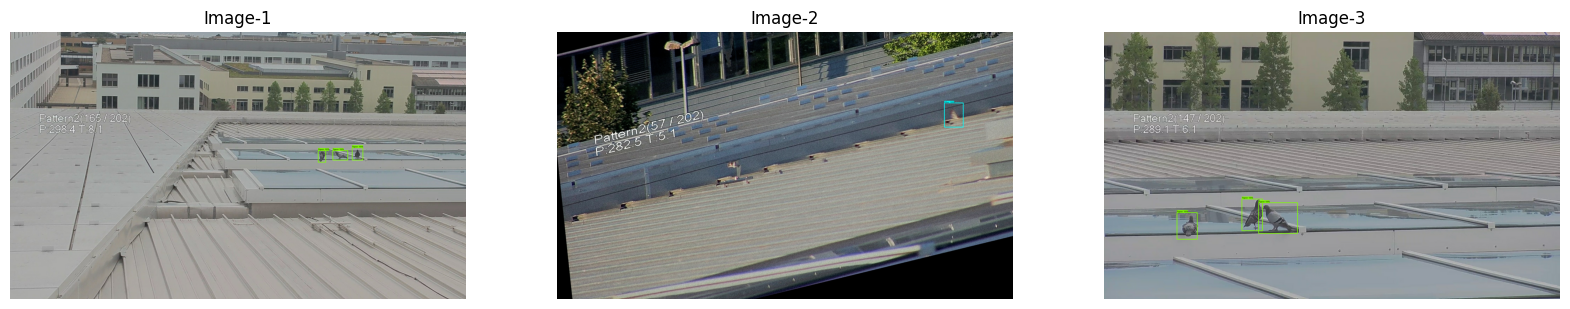

In [29]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

## Train and evaluate.

We follow the COCO challenge tradition to evaluate the accuracy of object detection based on mAP(mean Average Precision). Please check [here](https://cocodataset.org/#detection-eval) for detail explanation of how evaluation metrics for detection task is done.

**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted bounding box and ground truth bounding box.

In [30]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...


2025-01-14 19:11:34.994820: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 100...


2025-01-14 19:11:51.188490: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


train | step:    100 | steps/sec:    0.6 | output: 
    {'box_loss': 0.08760057,
     'cls_loss': 2.6282227,
     'learning_rate': 0.09755283,
     'model_loss': 7.0082526,
     'total_loss': 61.244297,
     'training_loss': 61.244297}
saved checkpoint to ./trained_model/ckpt-100.
 eval | step:    100 | running 100 steps of evaluation...


2025-01-14 19:14:45.704325: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-14 19:15:33.859560: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

2025-01-14 19:18:29.956610: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

2025-01-14 19:22:25.977135: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-14 19:23:20.102808: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.96s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

RuntimeError: The loss value is NaN after training loop and it happens 1 times.

train | step:    500 | steps/sec:    0.8 | output: 
    {'box_loss': 0.008003844,
     'cls_loss': 0.37224656,
     'learning_rate': 0.049999997,
     'model_loss': 0.77243865,
     'total_loss': 2.0097175,
     'training_loss': 2.0097175}


saved checkpoint to ./trained_model/ckpt-500.
 eval | step:    500 | running 100 steps of evaluation...


2023-11-09 12:27:03.978075: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

train | step:    600 | steps/sec:    0.8 | output: 
    {'box_loss': 0.0075427825,
     'cls_loss': 0.36228406,
     'learning_rate': 0.034549143,
     'model_loss': 0.739423,
     'total_loss': 1.9641409,
     'training_loss': 1.9641409}


saved checkpoint to ./trained_model/ckpt-600.
 eval | step:    600 | running 100 steps of evaluation...


2023-11-09 12:29:16.661897: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.26s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

train | step:    700 | steps/sec:    0.8 | output: 
    {'box_loss': 0.007070377,
     'cls_loss': 0.34681392,
     'learning_rate': 0.02061074,
     'model_loss': 0.7003328,
     'total_loss': 1.91634,
     'training_loss': 1.91634}


saved checkpoint to ./trained_model/ckpt-700.
 eval | step:    700 | running 100 steps of evaluation...


2023-11-09 12:31:29.396952: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.25s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

train | step:    800 | steps/sec:    0.8 | output: 
    {'box_loss': 0.006680321,
     'cls_loss': 0.3391388,
     'learning_rate': 0.009549147,
     'model_loss': 0.673155,
     'total_loss': 1.8838484,
     'training_loss': 1.8838484}


saved checkpoint to ./trained_model/ckpt-800.
 eval | step:    800 | running 100 steps of evaluation...


2023-11-09 12:33:41.871412: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

train | step:    900 | steps/sec:    0.8 | output: 
    {'box_loss': 0.006552434,
     'cls_loss': 0.3347254,
     'learning_rate': 0.002447176,
     'model_loss': 0.6623471,
     'total_loss': 1.8704419,
     'training_loss': 1.8704419}


saved checkpoint to ./trained_model/ckpt-900.
 eval | step:    900 | running 100 steps of evaluation...


2023-11-09 12:35:54.334538: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

train | step:   1000 | steps/sec:    0.8 | output: 
    {'box_loss': 0.0064173574,
     'cls_loss': 0.33288643,
     'learning_rate': 0.0,
     'model_loss': 0.6537543,
     'total_loss': 1.8610404,
     'training_loss': 1.8610404}


saved checkpoint to ./trained_model/ckpt-1000.
 eval | step:   1000 | running 100 steps of evaluation...


2023-11-09 12:38:06.900922: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

## Load logs in tensorboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './trained_model/'

## Saving and exporting the trained model.

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

## Inference from trained model

In [22]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### Visualize test data.

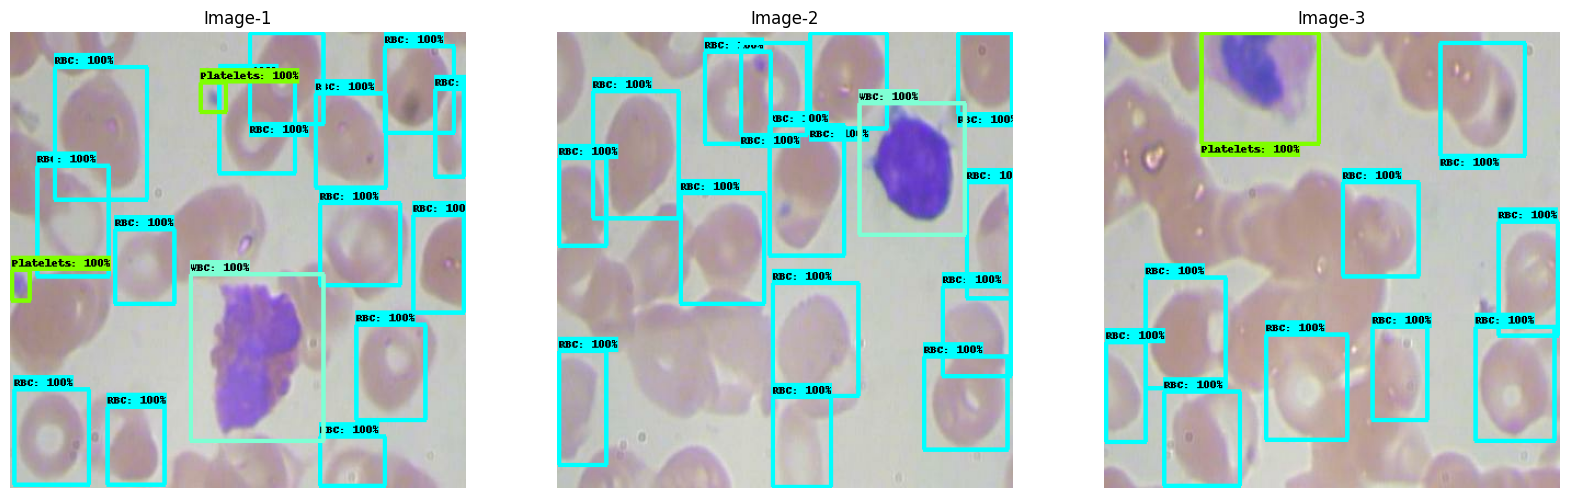

In [23]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    './bccd_coco_tfrecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

### Importing SavedModel.

In [24]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### Visualize predictions.

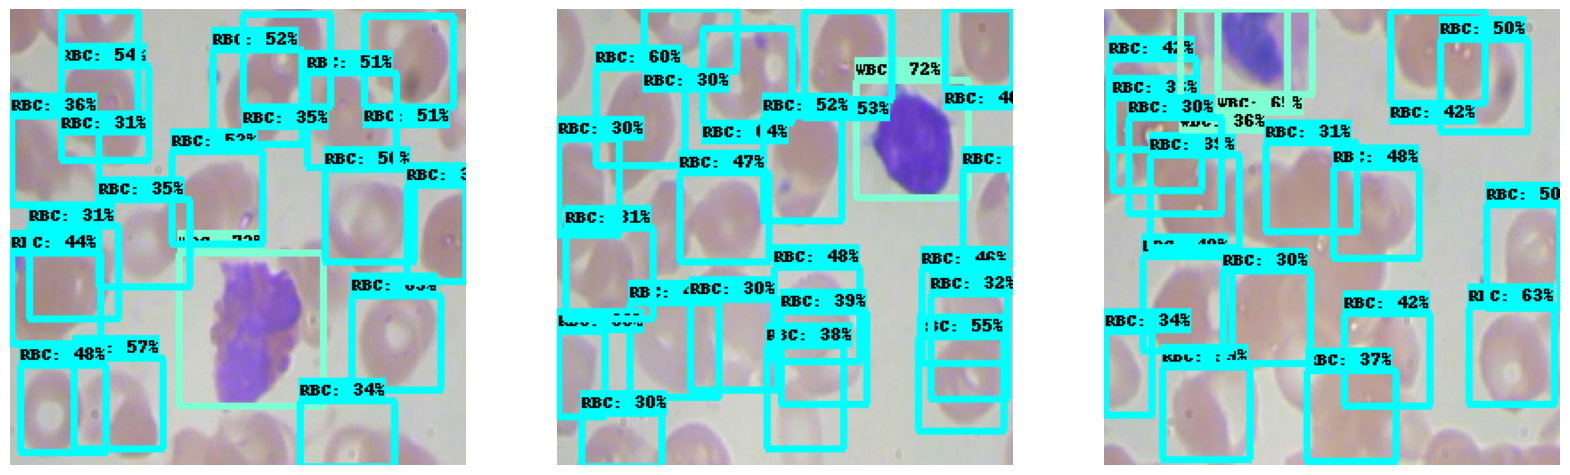

In [25]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.30 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()